In [1]:
import os
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.util as sku
import skimage.transform as skt

In [2]:
def calculate_displacement_euclidean(base_layer, target_layer, search_radius, initial_shift=(0, 0)):
    best_shift = initial_shift
    best_score = np.inf  

    for x_shift in range(initial_shift[0] - search_radius, initial_shift[0] + search_radius + 1):
        for y_shift in range(initial_shift[1] - search_radius, initial_shift[1] + search_radius + 1):
            shifted_target = np.roll(np.roll(target_layer, x_shift, axis=0), y_shift, axis=1)
            score = np.sum((base_layer - shifted_target) ** 2)
            if score < best_score:
                best_score = score
                best_shift = (x_shift, y_shift)

    return best_shift

In [3]:
def calculate_displacement_pyramid(base_img, target_img, scale_factor=0.5, search_range=10, max_layers=5):
    base_pyramid = [base_img]
    target_pyramid = [target_img]

    for _ in range(1, max_layers):
        base_img = skt.rescale(base_img, scale_factor, anti_aliasing=True)
        target_img = skt.rescale(target_img, scale_factor, anti_aliasing=True)
        base_pyramid.append(base_img)
        target_pyramid.append(target_img)

    best_shift = (0, 0)

    for i in range(max_layers - 1, -1, -1):
        base_layer = base_pyramid[i]
        target_layer = target_pyramid[i]

        best_shift = calculate_displacement_euclidean(base_layer, target_layer, search_range, best_shift)
        best_shift = (best_shift[0] * 2, best_shift[1] * 2)

    return best_shift

In [4]:
# File paths
inpath = r"D:\UCB\24Fall\CS180\Project work\proj1color\data"
outpath = r'D:\UCB\24Fall\CS180\Project work\proj1color\output'

# Get image names in the input directory
image_names = [f for f in os.listdir(inpath) if f.endswith(('.tif'))]

# Process each image
for img_name in image_names:
    imname = os.path.join(inpath, img_name)
    
    # Read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int64)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    # align the images
    g_shift = calculate_displacement_pyramid(b, g)
    r_shift = calculate_displacement_pyramid(b, r)

    # Apply the shifts
    ag = np.roll(np.roll(g, g_shift[0], axis=0), g_shift[1], axis=1)
    ar = np.roll(np.roll(r, r_shift[0], axis=0), r_shift[1], axis=1)


    # create a color image
    im_out = np.dstack([ar, ag, b])

    # display the image
    # skio.imshow(im_out)
    # skio.show()

    print(img_name, g_shift, r_shift)
    im_out = sku.img_as_ubyte(im_out)
    outname = os.path.join(outpath, f'{os.path.splitext(img_name)[0]}.jpg')
    skio.imsave(outname, im_out)

cathedral.jpg (2, -2) (14, -2)
church.tif (0, -10) (104, -12)
emir.tif (-6, 14) (214, 34)
harvesters.tif (236, -6) (240, 14)
icon.tif (84, 32) (178, 44)
lady.tif (114, -12) (246, -34)
melons.tif (166, 8) (352, 14)
monastery.jpg (-12, 0) (18, 2)
onion_church.tif (104, 44) (216, 70)
sample_flower.jpg (2, 2) (12, 2)
sample_house.jpg (8, 0) (18, 2)
sculpture.tif (66, -22) (280, -52)
self_portrait.tif (100, -4) (260, -10)
three_generations.tif (104, 10) (216, 14)
tobolsk.jpg (6, 4) (12, 6)
train.tif (222, -14) (214, 2)


In [8]:
# File paths
inpath = r"D:\UCB\24Fall\CS180\Project work\proj1color\data"
outpath = r'D:\UCB\24Fall\CS180\Project work\proj1color\output'

# Get image names in the input directory
image_names = [f for f in os.listdir(inpath) if f.endswith(('.jpg'))]

# Process each image
for img_name in image_names:
    imname = os.path.join(inpath, img_name)
    
    # Read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int64)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    # align the images
    g_shift = calculate_displacement_pyramid(b, g)
    r_shift = calculate_displacement_pyramid(b, r)

    # Apply the shifts
    ag = np.roll(np.roll(g, g_shift[0], axis=0), g_shift[1], axis=1)
    ar = np.roll(np.roll(r, r_shift[0], axis=0), r_shift[1], axis=1)


    # create a color image
    im_out = np.dstack([ar, ag, b])

    # display the image
    # skio.imshow(im_out)
    # skio.show()

    print(img_name, g_shift, r_shift)
    im_out = sku.img_as_ubyte(im_out)
    outname = os.path.join(outpath, f'{os.path.splitext(img_name)[0]}.jpg')
    skio.imsave(outname, im_out)

cathedral.jpg (2, -2) (14, -2)
monastery.jpg (-12, 0) (18, 2)
sample_flower.jpg (2, 2) (12, 2)
sample_house.jpg (8, 0) (18, 2)
tobolsk.jpg (6, 4) (12, 6)


In [5]:
def crop_image(image):
    # Compute the variance along each row and column
    row_variances = np.var(image, axis=1)  # Variance along rows
    col_variances = np.var(image, axis=0)  # Variance along columns

    # Find rows and columns where the variance exceeds the threshold (indicating the start of the actual image)
    threshold = 0.05  # Adjust this value as needed
    top = np.argmax(row_variances > threshold)
    bottom = len(row_variances) - np.argmax(np.flipud(row_variances) > threshold)

    left = np.argmax(col_variances > threshold)
    right = len(col_variances) - np.argmax(np.flipud(col_variances) > threshold)

    # Crop the image based on the detected borders
    return image[top:bottom, left:right]


(2, 2) (12, 2)


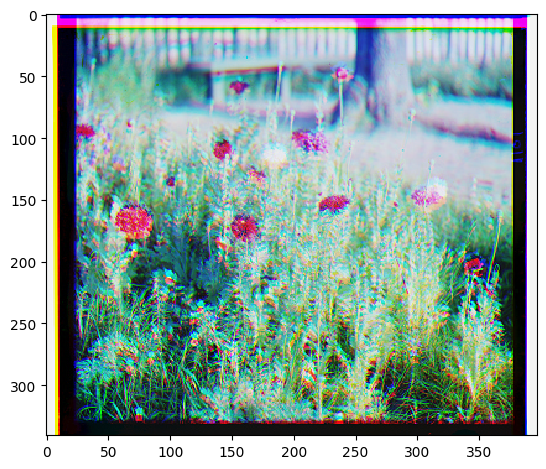

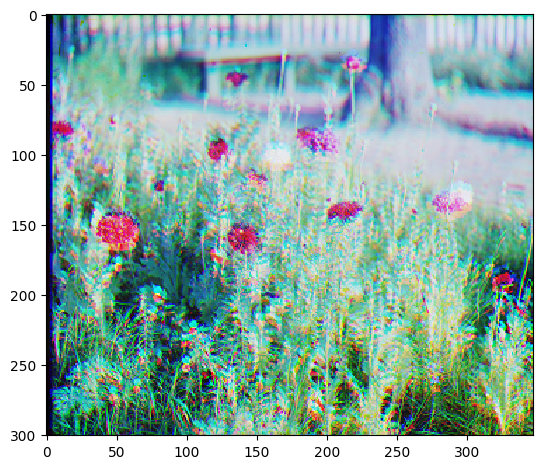

In [6]:
# flower as a single sample
imname = 'sample_flower.jpg'

im = skio.imread(imname)
im = sk.img_as_float(im)
height = np.floor(im.shape[0] / 3.0).astype(np.int64)
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]
g_shift = calculate_displacement_pyramid(b, g)
r_shift = calculate_displacement_pyramid(b, r)

print(g_shift, r_shift)
ag = np.roll(np.roll(g, g_shift[0], axis=0), g_shift[1], axis=1)
ar = np.roll(np.roll(r, r_shift[0], axis=0), r_shift[1], axis=1)
im_out = np.dstack([ar, ag, b])
skio.imshow(im_out)
skio.show()
im_out = crop_image(im_out)
skio.imshow(im_out)
skio.show()

In [7]:
# File paths
inpath = r"D:\UCB\24Fall\CS180\Project work\proj1color\data"
outpath = r'D:\UCB\24Fall\CS180\Project work\proj1color\output'

# Get image names in the input directory
image_names = [f for f in os.listdir(inpath) if f.endswith(('.jpg'))]

# Process each image
for img_name in image_names:
    imname = os.path.join(inpath, img_name)
    
    # Read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int64)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    # align the images
    g_shift = calculate_displacement_pyramid(b, g)
    r_shift = calculate_displacement_pyramid(b, r)

    # Apply the shifts
    ag = np.roll(np.roll(g, g_shift[0], axis=0), g_shift[1], axis=1)
    ar = np.roll(np.roll(r, r_shift[0], axis=0), r_shift[1], axis=1)


    # create a color image
    im_out = np.dstack([ar, ag, b])
    im_out = crop_image(im_out)

    print(img_name, g_shift, r_shift)
    im_out = sku.img_as_ubyte(im_out)
    outname = os.path.join(outpath, f'{os.path.splitext(img_name)[0]}_cropped.jpg')
    skio.imsave(outname, im_out)

cathedral.jpg (2, -2) (14, -2)
monastery.jpg (-12, 0) (18, 2)
sample_flower.jpg (2, 2) (12, 2)
sample_house.jpg (8, 0) (18, 2)
tobolsk.jpg (6, 4) (12, 6)
